In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import LowessSmoother
from statsmodels.tsa.stattools import grangercausalitytests
import requests
import IPython
from ipyleaflet import Map, Heatmap

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# data preparation and exploration

since the data-set is huge, for the sake of reproductivity we started our analysis on the data only of 2018

In [3]:
df_sens = pd.read_csv('data/traffic_flow_2018.csv', encoding= 'unicode_escape')
df_noise=pd.read_csv('data/noise_level_2018.csv', encoding= 'unicode_escape')
df_loc=pd.read_csv('data/data_entities.csv', encoding= 'unicode_escape')


lets convert the dates in the standard datetime format 

In [4]:
df_sens['dateobservedfrom'] = pd.to_datetime(df_sens['dateobservedfrom'], infer_datetime_format=True)
df_sens['dateobservedto'] = pd.to_datetime(df_sens['dateobservedto'], infer_datetime_format=True)

now we drop some useless column 

In [5]:
df_sens=df_sens.drop(columns=['dataprovider','source','lanedirection','entity_type'])


In [6]:
df_sens.head(5)

,entity_id,dateobservedfrom,dateobservedto,intensity,laneid,date_from,time_from,name
0,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2017-12-31 03:25:00,2017-12-31 03:30:00,28,1,2017-12-31,03:25:00.0000000,R. Constituição - Faria Guimarães
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2017-12-31 04:05:00,2017-12-31 04:10:00,16,1,2017-12-31,04:05:00.0000000,R. Constituição - Faria Guimarães
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2017-12-31 10:35:00,2017-12-31 10:40:00,16,1,2017-12-31,10:35:00.0000000,R. Faria Guimarães - Constituição
3,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2017-12-31 11:30:00,2017-12-31 11:35:00,22,1,2017-12-31,11:30:00.0000000,R. Faria Guimarães - Constituição
4,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2017-12-31 11:55:00,2017-12-31 12:00:00,29,1,2017-12-31,11:55:00.0000000,R. Faria Guimarães - Constituição


the sensor data have different parameters:
- entity id -> that represent the univoque identifier of a sensor
- dateobservedfrom/dateobservedto -> that represents the time slot in with a measure was made
- intensity -> number of cars that passed in that timeslot 
- name  -> the name of the street 

to explore better the data we are going to isolate the traffic of the whole city but at a single day

In [7]:

df_sens_an=df_sens[(df_sens["dateobservedfrom"].dt.date==datetime.date(datetime(2018, 3, 20)))]

In [8]:
df_sens_an.head(10)

,entity_id,dateobservedfrom,dateobservedto,intensity,laneid,date_from,time_from,name
524922,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 21:20:00,2018-03-20 21:25:00,90,1,2018-03-20,21:20:00.0000000,R. Tenente Valadim
524923,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 21:35:00,2018-03-20 21:40:00,57,1,2018-03-20,21:35:00.0000000,R. Tenente Valadim
524924,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 23:05:00,2018-03-20 23:10:00,225,1,2018-03-20,23:05:00.0000000,R. Tenente Valadim
524925,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 23:10:00,2018-03-20 23:15:00,492,1,2018-03-20,23:10:00.0000000,R. Tenente Valadim
524926,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 23:20:00,2018-03-20 23:25:00,72,1,2018-03-20,23:20:00.0000000,R. Tenente Valadim
524927,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 23:45:00,2018-03-20 23:50:00,59,1,2018-03-20,23:45:00.0000000,R. Tenente Valadim
524928,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 23:50:00,2018-03-20 23:55:00,89,1,2018-03-20,23:50:00.0000000,R. Tenente Valadim
524929,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 14:10:00,2018-03-20 14:15:00,29,1,2018-03-20,14:10:00.0000000,Av.Boavista - E-O
524930,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 15:30:00,2018-03-20 15:35:00,36,1,2018-03-20,15:30:00.0000000,Av.Boavista - E-O
524931,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 15:45:00,2018-03-20 15:50:00,26,1,2018-03-20,15:45:00.0000000,Av.Boavista - E-O


lets plot the traffic levels on a single street:

In [9]:
cit=df_sens_an[(df_sens_an["name"]=="Av. Aliados")]
cit=cit.sort_values(by=["dateobservedfrom"])


since the data of the sensors is noisy we have to smooth it, to do so we used a localised regression, that is ideal for smoothing traffic sensor data, because is non parametric and do not assume any prior distribution of the data.

In [10]:
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smoother.smooth(cit["intensity"])

# generate intervals
low, up = smoother.get_intervals('prediction_interval')


C:\Users\michele\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


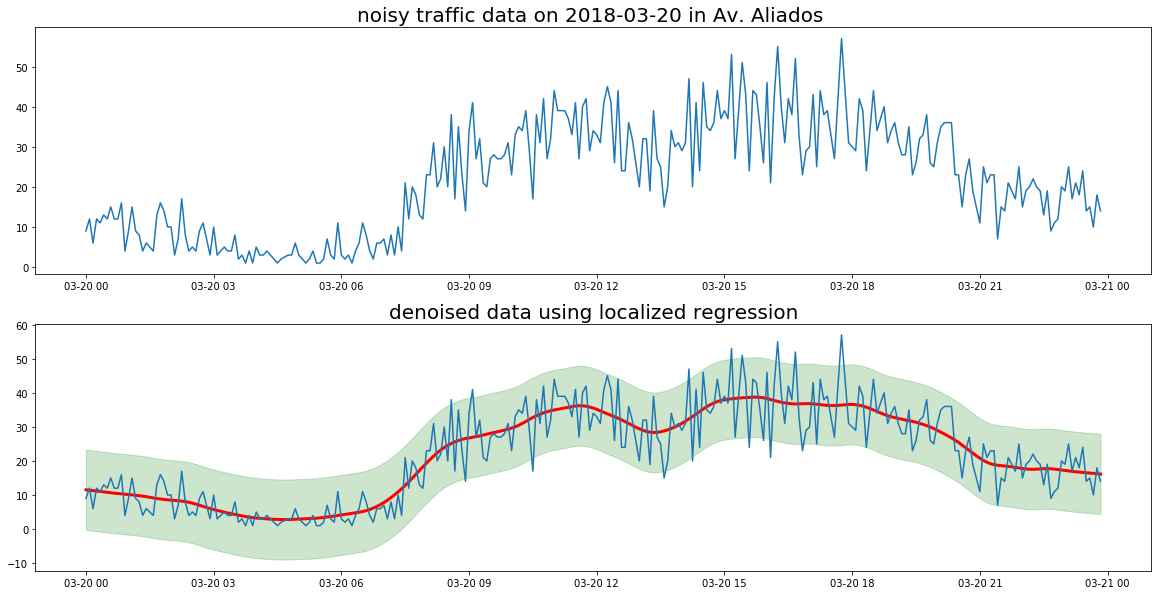

In [11]:


plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
#original time series
plt.plot(cit["dateobservedfrom"],cit["intensity"])
plt.title("noisy traffic data on 2018-03-20 in Av. Aliados " ,fontsize=20)
plt.subplot(2, 1, 2)
#plot the the original timeseries 
plt.plot(cit["dateobservedfrom"],smoother.smooth_data[0],linewidth=3, color='red')
#add the smoothed one
plt.plot(cit["dateobservedfrom"],smoother.data[0])
plt.fill_between(cit["dateobservedfrom"], low[0], up[0], alpha=0.2,color="green")
plt.title("denoised data using localized regression", fontsize=20)
plt.show()


as is possible to see in the first picture, the sensor data in this timeseries is pretty noisy, so to be used for estimation need to be smoothed; in the picture below is it possible to see the fitted line resulting in applying a localised regression on the data 

lets isolate now the result obtained from the smoothing

In [12]:
cit["intensity"]=smoother.smooth_data[0]

Text(0.5, 1.0, 'denoised result')

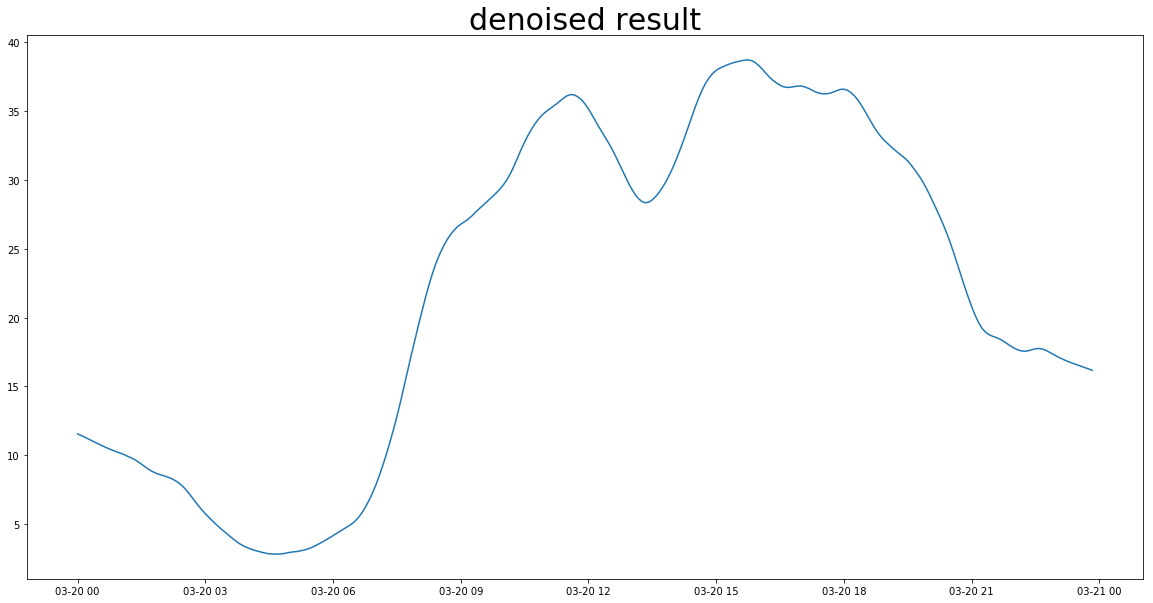

In [13]:
plt.figure(figsize=(20,10))
plt.plot(cit["dateobservedfrom"],cit["intensity"])
plt.title("denoised result", fontsize=30)

as expected we can see that the traffic level will decrease at night (at 3 in the morning is almost 0), and then reach its peak at the rush hours (12:00, 15:00)

# the intuition 

predicting traffic isolating street by street using previous value and  its corresponding panel data(noise level, weather, pollution...) for estimation do not make much sense, because actually in this way we are going to lose a lot of informations regarding the relations of the traffic levels BETWEEN streets.

Infact  the traffic level of a street at a particular time will probably be dependent by the traffic level of a nearby street 5 minutes earlier or with a more distant street 10 minutes earlier.... 
So recapping for this problem we want  also to capture the spacial value of nearby streets with   previous time levels. 

To show the execution practically we first isolate another street 

In [14]:
cit2=df_sens_an[(df_sens_an["name"]=="Av.Boavista - O-E")]
cit2=cit2.sort_values(by=["dateobservedfrom"])


let's now denoise it in the same way we did with the previous street 

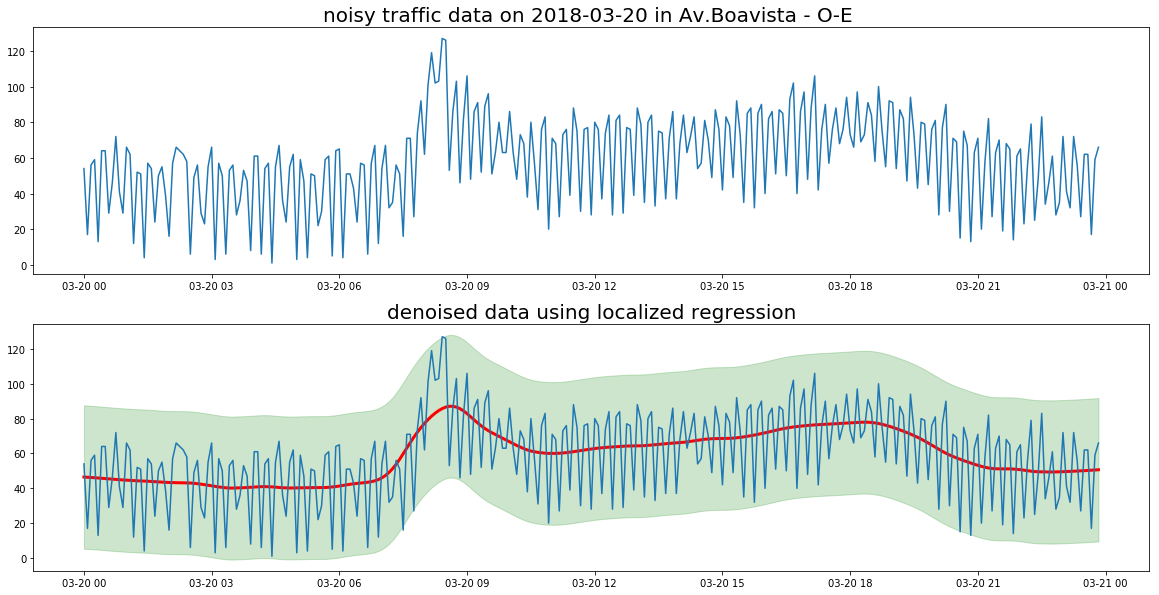

In [15]:
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smoother.smooth(cit2["intensity"])


low, up = smoother.get_intervals('prediction_interval')
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(cit2["dateobservedfrom"],cit2["intensity"])
plt.title("noisy traffic data on 2018-03-20 in Av.Boavista - O-E " ,fontsize=20)
plt.subplot(2, 1, 2)
plt.plot(cit2["dateobservedfrom"],smoother.smooth_data[0],linewidth=3, color='red')
plt.plot(cit2["dateobservedfrom"],smoother.data[0])
plt.fill_between(cit2["dateobservedfrom"], low[0], up[0], alpha=0.2,color="green")
plt.title("denoised data using localized regression", fontsize=20)
plt.show()

In [16]:
cit2["intensity"]=smoother.smooth_data[0]

now lets isolate the smoothed time series 

Text(0.5, 1.0, 'denoised result')

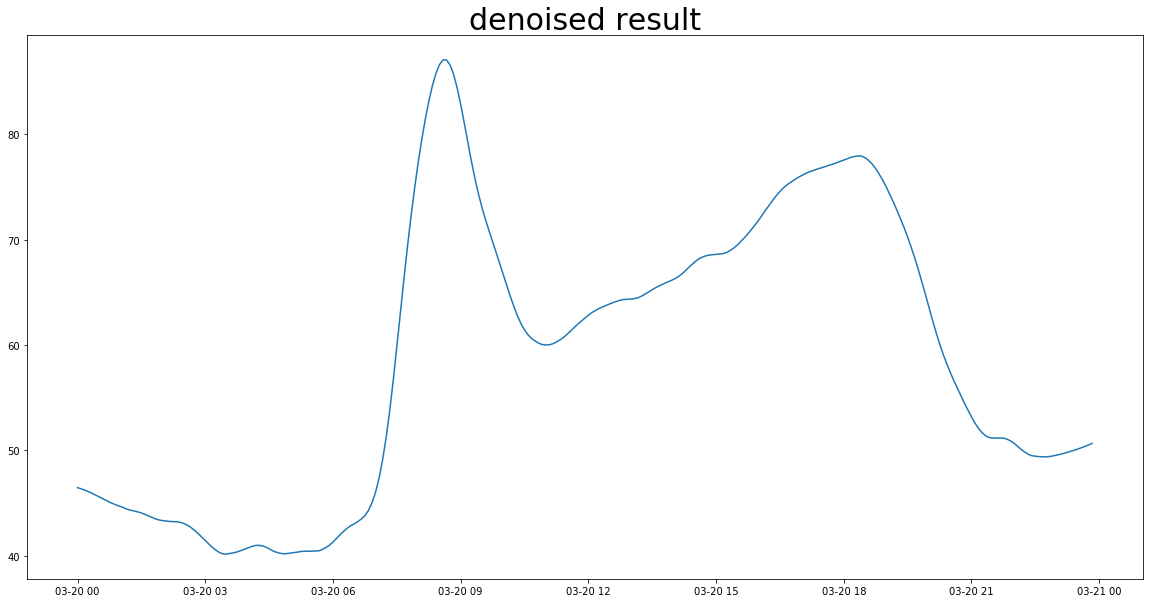

In [17]:
plt.figure(figsize=(20,10))
plt.plot(cit2["dateobservedfrom"],cit2["intensity"])
plt.title("denoised result", fontsize=30)

this is definitely a really busy street, but it's main behaviour remained the same, it has a peak at 9:00 and another at 18:00 suggesting this street is used a lot by people that go to work, there is a probable presence of offices or similar premises.

now we merge each entity id if of the traffic data  with its corresponding entity id of the data entity dataset to know the latitude and longitude of each measurement taken by each sensor 

In [18]:
cit=cit.merge(df_loc[["entity_id","name","latitude","longitude"]],how="left",left_on="entity_id",right_on="entity_id")

In [19]:
cit2=cit2.merge(df_loc[["entity_id","name","latitude","longitude"]],how="left",left_on="entity_id",right_on="entity_id")

now we merge the two datasets we obtained on the measured time, to sincronise the time series

In [20]:
test=cit.merge(cit2,how="left",left_on='dateobservedfrom',right_on='dateobservedfrom')

In [21]:
test=test.dropna()

In [22]:
test.head(10)

,entity_id_x,dateobservedfrom,dateobservedto_x,intensity_x,laneid_x,date_from_x,time_from_x,name_x_x,name_y_x,latitude_x,...,entity_id_y,dateobservedto_y,intensity_y,laneid_y,date_from_y,time_from_y,name_x_y,name_y_y,latitude_y,longitude_y
0,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:00:00,2018-03-20 00:05:00,11.530186,1,2018-03-20,00:00:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:05:00,46.444230,1.0,2018-03-20,00:00:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:05:00,2018-03-20 00:10:00,11.416281,1,2018-03-20,00:05:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:10:00,46.341173,1.0,2018-03-20,00:05:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:10:00,2018-03-20 00:15:00,11.296620,1,2018-03-20,00:10:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:15:00,46.218765,1.0,2018-03-20,00:10:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434
3,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:15:00,2018-03-20 00:20:00,11.171940,1,2018-03-20,00:15:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:20:00,46.079706,1.0,2018-03-20,00:15:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434
4,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:20:00,2018-03-20 00:25:00,11.043985,1,2018-03-20,00:20:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:25:00,45.926401,1.0,2018-03-20,00:20:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434
5,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:25:00,2018-03-20 00:30:00,10.914885,1,2018-03-20,00:25:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:30:00,45.760501,1.0,2018-03-20,00:25:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434
6,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:30:00,2018-03-20 00:35:00,10.786984,1,2018-03-20,00:30:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:35:00,45.588065,1.0,2018-03-20,00:30:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434
7,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:35:00,2018-03-20 00:40:00,10.662593,1,2018-03-20,00:35:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:40:00,45.414246,1.0,2018-03-20,00:35:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434
8,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:40:00,2018-03-20 00:45:00,10.543872,1,2018-03-20,00:40:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:45:00,45.242100,1.0,2018-03-20,00:40:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434
9,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:45:00,2018-03-20 00:50:00,10.432348,1,2018-03-20,00:45:00.0000000,Av. Aliados,Av. Aliados,41.146933,...,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,2018-03-20 00:50:00,45.076890,1.0,2018-03-20,00:45:00.0000000,Av.Boavista - O-E,Av.Boavista - O-E,41.167447,-8.686434


as is possible to see now we can know what are the traffic level of the two streets at the same moments, and if we plot them

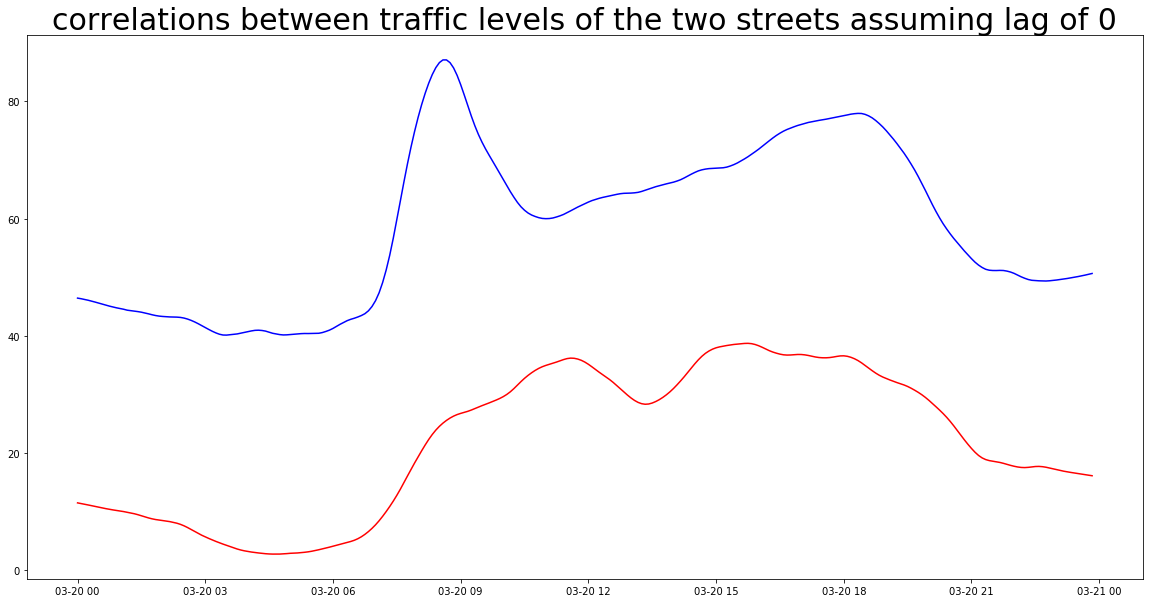

In [23]:
plt.figure(figsize=(20,10))
plt.title("correlations between traffic levels of the two streets assuming lag of 0",fontsize=30)
plt.plot(test["dateobservedfrom"],test["intensity_x"],color='red')
plt.plot(test["dateobservedfrom"],test["intensity_y"],color='blue')

to know how much the traffic of the red line will exlplain the traffic of the blue line we need to add a lag for the red one "how much time before we should evaluate each point of the red line", eg. with a lag of 1 we see how much is correlated the traffic of the first street with the traffic of the second street 5 minutes earlier, with a lag of 2  we see how much is correlated the traffic of the first street with the traffic of the second street 10 minutes earlier...and so on ) 

## determining the optimal lag

the optimal lag is clearly the travel time between the two streets taking in consideration the historic traffic levels, however is not an easy task to find a function that maps the intensity of traffic at some given roads with the time of travel that road, because it clearly depends on some data we dont have, for example the number of lanes, or the average speed, so we solved this task using  HERE Routing API v8.21.6 that introduced the possibility of obtaining historic time of travel based on historic traffic data.

First of all we gather the location data of the 2 sensor 

In [24]:
lat_x=test.head(1)["latitude_x"][0]
lon_x=test.head(1)["longitude_x"][0]
lat_y=test.head(1)["latitude_y"][0]
lon_y=test.head(1)["longitude_y"][0]

then we request the optimal route between the two points at a given time  and we sum the travel time for each road segment 

In [25]:
res=requests.get("https://router.hereapi.com/v8/routes?transportMode=car&origin="+str(lat_x)+","+str(lon_x)+"&destination="+str(lat_y)+","+str(lon_y)+"&return=summary&departureTime=2018-03-20T13:05:00&apiKey=__M4jTOKfFKNfDLlFxF1ZtMv8YeR4XVTKx7RgQR0_oE")



json=res.json()
json

{'routes': [{'id': '8fd161e1-860b-44a1-84fa-06ba0e0e17aa',
   'sections': [{'id': '89eb9591-0a15-4f98-b332-b2de6ca72aff',
     'type': 'vehicle',
     'departure': {'time': '2018-03-20T13:05:00+00:00',
      'place': {'type': 'place',
       'location': {'lat': 41.1469, 'lng': -8.61114},
       'originalLocation': {'lat': 41.1469332, 'lng': -8.6111291}}},
     'arrival': {'time': '2018-03-20T13:19:58+00:00',
      'place': {'type': 'place',
       'location': {'lat': 41.1674502, 'lng': -8.6864331},
       'originalLocation': {'lat': 41.1674469, 'lng': -8.6864341}}},
     'summary': {'duration': 898, 'length': 8348, 'baseDuration': 898},
     'transport': {'mode': 'car'}}]}]}

In [26]:
dist=0
for i in range(len(json["routes"][0]["sections"])):
               dist=dist+json["routes"][0]["sections"][i]["summary"]["duration"]

we then convert the historical time of travel at the given day in blocks of 5 minutes(our scale) 

In [27]:
lag=round(dist/(60*5))

In [28]:
lag 

3

and we have finally our lag ( 3 block of 5 minutes) meaning 15 minutes of distance time between the 2 points. (taking in consideration the historic traffic) 

Once we have the lag level we need only to compare the two time series and check if there is causality between them .

The main idea is that if the second time series ( the lagged one ) cause the first, then the forecast of the first time series based on previous values of the first AND the second timeseries should outperform the forecast  using ONLY the previous values of the first timeseries 

To have a metric for this finding we wanted to use hypotesis testing, and fortunately there exists a type of test that is really fitted for our problem, this test is called grangercausality, and have as  null hypotesis of the fact that the second series, do not cause the first.

So we runned the test at the lag level previously found 

In [29]:
weight=grangercausalitytests(test[['intensity_x', 'intensity_y']],[lag])[lag][0]["ssr_ftest"][1]


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1516  , p=0.3287  , df_denom=274, df_num=3
ssr based chi2 test:   chi2=3.5430  , p=0.3152  , df=3
likelihood ratio test: chi2=3.5209  , p=0.3181  , df=3
parameter F test:         F=1.1516  , p=0.3287  , df_denom=274, df_num=3


as is possible to see the pvalue of the f-test is 0.3287>0.05(our alpha level).
That means that the null hypotesis cannot be rejected, meaning that on 2018-03-20 at 13:05:00  the traffic levels of that street( Av. Aliados) do not depended on the traffic levels of the other street(Av.Boavista - O-E) 15 minutes priorly, this result is expected since we picked the 2 streets at random and they are quite distant between each other.

however the obtained p-value could be an important variable to be used for training the data for prediction we can convert the pvalue in an actual weight to be used afterwards  

In [30]:
weight=1-weight
weight

0.6712956473965539

this weight founds (0.67) represent how much is the traffic level on 2018-03-20 at 13:05:00 of Av. Aliados explained by the trffic level of Av.Boavista - O-E some minutes priorly.

Nearest streets will have expectidly lower travel time and so a higher final weight, according to tobler's first law of geography "everything is related to everything else, but near things are more related than distant things."

# scaling the problem

the next step to do is to adapt all the methods we have just seen with 2 streets and a datetime to all the possible pair of streets in the city at a given time creating so an adjacency matrix of weights, and then finally do the same for each different time level.
in this  way we will have a new dataset that could bring a lot of value for the prediction because it captures the relations between streets 

so lets create the adjacency matrix regarding the time in the example: 2018-03-20 at 13:05:00

first of all we merge the whole dataset with the location of the sensors, as seen in the small example before 

In [31]:
df_sens_an=df_sens_an.merge(df_loc[["entity_id","name","latitude","longitude"]],how="left",left_on="entity_id",right_on="entity_id")

then we group the data by street, having as a result a  timeseries for each street, that explains the evolution of traffic that day .


We then smooth each timeseries

In [32]:
#to avoid division by 0 whenever a streets have 0 car passing by i will add 1 of them, 
df_sens_an["intensity"]=df_sens_an["intensity"].apply(lambda x: x+1 if ((x<1)|(x==None)) else x)
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
#first we group the whole sensor data(of that day) by street
df_sens_grouped=df_sens_an.groupby(["name_x"])
altered = []
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
for index, subframe in df_sens_grouped:
    
    #then we sort each group in chronological order
    subframe=subframe.sort_values(by=["dateobservedfrom"])
    #then we smooth each group intensity data 
    smoother.smooth(subframe["intensity"])
    subframe["intensity"]=smoother.smooth_data[0]
    

    
    altered.append(subframe)
    
    

df_sens_an = pd.concat(altered)






lets see the results with one street 

In [33]:
test2=df_sens_an[(df_sens_an["name_x"]=="Avenida do Bessa")]

Text(0.5, 1.0, 'denoised result Av. Aliados on 2018-03-20')

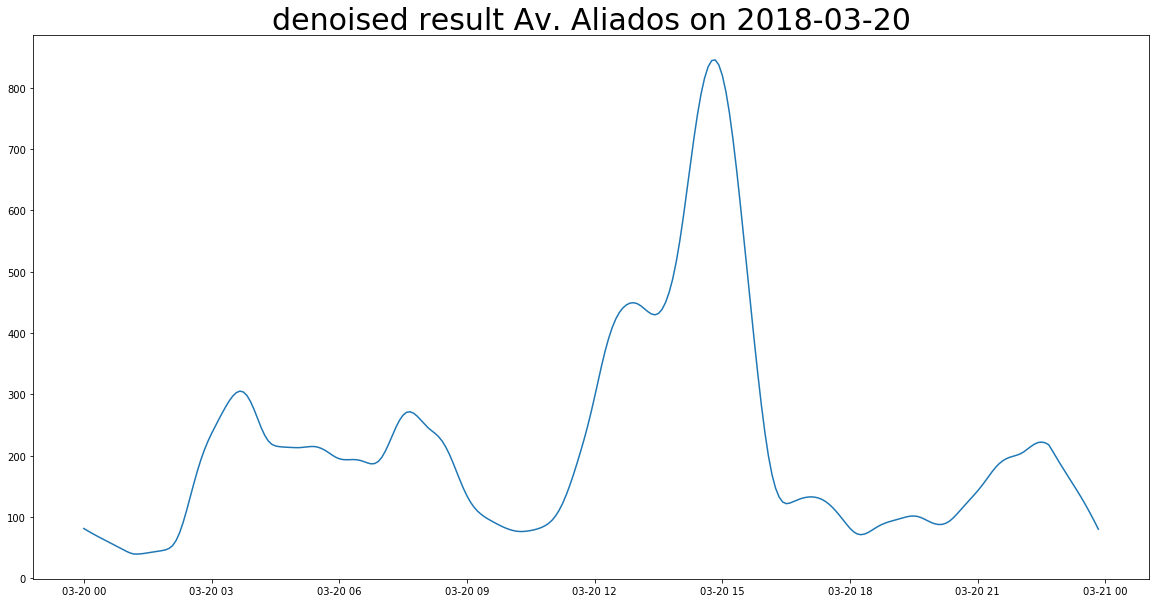

In [34]:
plt.figure(figsize=(20,10))
plt.plot(test2["dateobservedfrom"],test2["intensity"])
plt.title("denoised result Av. Aliados on 2018-03-20", fontsize=30)

we can now create the adjacency matrix for a fixed time (2018-03-20 at 13:00:00)

first of all we create a new feature called hour(will be used later)

In [35]:
df_sens_an["hour"]=df_sens_an["dateobservedfrom"].dt.hour

then we group each timeseries again by name 

In [36]:
#df_sens_grouped=df_sens_an.groupby(["name_x","hour"]).mean().reset_index()
df_sens_grouped=df_sens_an.groupby(["name_x"])

we finally create a new variable called date that will represent our date and time from with we want to test the relationship between streets.
the meaning that the we are now computing the matrix of relations of the traffic of each street with all the ohers at a fixed date and time, in this example 2018-03-2020 at 13:00

In [37]:
date=datetime(2018,3,20,13,0) 


now the matrix is created:
- take each pair of street
- use HERE routing v8 historic traffic data to take the exact time of travelling for the two streets
- lag the second timeseries inserting a time delay equal to the travel time 
- compute the mean square error of our timeseries and the lagged one  to get the weigh(lower is the weight more similar are the two traffic levels.
- repeat for each street couple 

a little remark, to compute the difference between our time series and the lagged one we used the mean squared error, because those time series are clearly not stationary,because they are all time dependent, in fact in the early morning they all decrease and in the afternoon they all present a peak 


In [ ]:
#df_sens_grouped=df_sens_grouped.groupby(["name_x"])
ncities=df_sens_grouped.ngroups
timematrix= np.zeros((ncities,ncities))
weightmatrix=np.zeros((ncities,ncities),dtype='f,f,f,f,f,f,U30,U30')

g=0
f=0
date=datetime(2018,3,20,13,0) 
for index,subframe in df_sens_grouped:
    subframe_an=subframe[((date.hour-subframe["hour"])<=3)&((date-subframe["dateobservedfrom"]).dt.days==0)].copy()
    if len(subframe_an)<37:
        continue

    lat_x=subframe_an.iloc[0]["latitude"]
    lon_x=subframe_an.iloc[0]["longitude"]
    f=0
    
    for index1, subframe1 in  df_sens_grouped:
        
        subframe1_an=subframe1[((date.hour-subframe1["hour"])<=3)&((date-subframe1["dateobservedfrom"]).dt.days==0)].copy()
    
        if len(subframe1_an)<37:
            continue
        lat_y=subframe1_an.iloc[0]["latitude"]
        lon_y=subframe1_an.iloc[0]["longitude"]
        test=subframe_an.merge(subframe1_an,how="inner",left_on='dateobservedfrom',right_on='dateobservedfrom')
        test=test.dropna()
        dist=0

        if(len(test[['intensity_x', 'intensity_y']])<37):
            continue
            
        
        res=requests.get("https://router.hereapi.com/v8/routes?transportMode=car&origin="+str(lat_x)+","+str(lon_x)+"&destination="+str(lat_y)+","+str(lon_y)+"&return=summary&departureTime=2018-03-20T13:00:00&apiKey=2yUtuxzFCoarL1pqmmJj8rGqnnCeZIx8dM8TSuW6eyo")
        json=res.json()
        
        for i in range(len(json["routes"][0]["sections"])):
            
               dist=dist+json["routes"][0]["sections"][i]["summary"]["duration"]
             
        
        lag=round(dist/(60*5)) #to be fixed change also timeframe because pedicting tradffic hourly do not akes sense
        
        
        test[["dateobservedto_y","intensity_y","laneid_y","date_from_y","time_from_y","name_x_y","name_y_y","latitude_y","longitude_y","hour_y"]] = test[["dateobservedto_y","intensity_y","laneid_y","date_from_y","time_from_y","name_x_y","name_y_y","latitude_y","longitude_y","hour_y"]].shift(lag)
        
        print(len(test[['intensity_x', 'intensity_y']]))
       # weight=grangercausalitytests(test[['intensity_x', 'intensity_y']],[lag],verbose=False)[lag][0]["ssr_ftest"][1]
        #weight=1-weight
        test=test.dropna()
        test["diff_quad"]=(test["intensity_x"]-test["intensity_y"])**2
        weight=test["diff_quad"].mean()
        weightmatrix[g][f]=(weight,dist,lat_x,lon_x,lat_y,lon_y,index,index1)
        print("i="+str(g)+" f="+str(f)+" val="+str(dist)+" weight="+str(weight))
        f=f+1
        
        
        
    g=g+1
    

    
    

once we have our adjacency matrix, we save it in a dataframe 

In [44]:
latx=[]
lonx=[]
laty=[]
lony=[]
time=[]
weight=[]
start=[]
end=[]
for i in range(len(weightmatrix)):
    for j in range(len(weightmatrix[i])):
        if (weightmatrix[i][j][0]!=0):
            weight.append(weightmatrix[i][j][0])
            time.append(weightmatrix[i][j][1])
            latx.append(weightmatrix[i][j][2])
            lonx.append(weightmatrix[i][j][3])
            laty.append(weightmatrix[i][j][4])
            lony.append(weightmatrix[i][j][5])
            start.append(weightmatrix[i][j][6])
            end.append(weightmatrix[i][j][7])
rel= {'start': start, 'end': end, 'weight': weight,'travel_time':time,'lat_start':latx,'lon_start':lonx,'lat_end':laty,'lon_end':lony}
relations = pd.DataFrame(data=rel)

here is our resulting dataframe, weight represents the error, so lower it is, the more the two streets are related 

In [71]:
relations.head(10)

,start,end,weight,travel_time,lat_start,lon_start,lat_end,lon_end
0,Alameda das Antas,Av. Aliados,37.516933,438.0,41.163254,-8.586267,41.146935,-8.611129
1,Alameda das Antas,Av. D. Afonso Henriques,1664.068970,480.0,41.163254,-8.586267,41.144810,-8.610845
2,Alameda das Antas,Av. Fernão Magalhães,2.717784,139.0,41.163254,-8.586267,41.157761,-8.593809
3,Alameda das Antas,Av. Fernão Magalhães - 24 de A,910.430786,222.0,41.163254,-8.586267,41.151497,-8.597432
4,Alameda das Antas,Av. Fernão Magalhães - N-S,6050.711914,98.0,41.163254,-8.586267,41.165325,-8.589031
5,Alameda das Antas,Av. Fernão Magalhães N-S - Tún,95.369049,104.0,41.163254,-8.586267,41.164806,-8.589134
6,Alameda das Antas,Av. Fernão de Magalhães - Fran,45.040298,122.0,41.163254,-8.586267,41.163433,-8.590074
7,Alameda das Antas,Av. Rodrigues de Freitas,12.592082,394.0,41.163254,-8.586267,41.145782,-8.600481
8,Alameda das Antas,Av. Rodrigues de Freitas - S.,107.950706,417.0,41.163254,-8.586267,41.145645,-8.602294
9,Alameda das Antas,Av.Boavista - E-O,17.590204,678.0,41.163254,-8.586267,41.167431,-8.685493


we then export it in csv for future uses 

In [46]:
relations.to_csv("relations_on_2018-03-20T_13_00.csv",index=False)

In [47]:
df_rel= pd.read_csv('relations_on_2018-03-20T_13_00.csv') #to be removed 

## example of one street 

we want now to show an example on how the traffic of one street is related to a subset of near streets of the city 

first of all we take an example street from our dataframe of relations: Alameda das Antas.

we then take some near street, and for near street we intend all the streets that have a travel time < 300 seconds(5 minutes) to our example street

In [49]:
locations = df_rel[(df_rel["start"]=="Alameda das Antas")&(df_rel["travel_time"]<300)&(df_rel["weight"]<1000)]
locations=locations[["lat_end","lon_end","weight"]]

here are the streets 

In [50]:
locations

,lat_end,lon_end,weight
2,41.157761,-8.593809,2.717784
3,41.151497,-8.597432,910.430786
5,41.164806,-8.589134,95.369049
6,41.163433,-8.590074,45.040298
20,41.162491,-8.611223,169.544525
21,41.161957,-8.611275,7.377063
22,41.161449,-8.611431,372.942139
23,41.160728,-8.611552,13.063189
24,41.163822,-8.611062,212.581604
25,41.163101,-8.611053,10.961776


since the weight is treated as a cost in this analysis we now want to negativize it so results closer to 0 are considered better than results more distant from 0 

In [51]:
locations["weight"]=-locations["weight"]

we now normalize each weight in a (0-1) scale 

In [52]:
locations["weight"]=(locations["weight"]-locations["weight"].min())/(locations["weight"].max()-locations["weight"].min())

this is our final dataframe of locations 

In [53]:
locations

,lat_end,lon_end,weight
2,41.157761,-8.593809,1.000000
3,41.151497,-8.597432,0.079648
5,41.164806,-8.589134,0.906059
6,41.163433,-8.590074,0.957088
20,41.162491,-8.611223,0.830850
21,41.161957,-8.611275,0.995276
22,41.161449,-8.611431,0.624621
23,41.160728,-8.611552,0.989511
24,41.163822,-8.611062,0.787214
25,41.163101,-8.611053,0.991641


In [54]:
records = locations.to_records(index=False)

we can now plot a map showing those relations found

In [56]:




m = Map(center=(41.161380643803504,-8.600300339285814), zoom=15)

heatmap = Heatmap(
    locations=list(map(list, list(records))),
    radius=30,
    max=0.3,
    blur=20,
    
  
    
)

m.add_layer(heatmap);

In [62]:
m.save('map_relations_Alameda_das_Antason_2018-03-20T_13_00.html', title='My Map')


### how traffic of Alameda das Antas depends  to the traffic of the other streets of the city 

here is possible to see how the traffic of Alameda das Antas is related to the traffic of the other streets of the city on 2018-03-20 at  13_00, more red is it more related are the streets, clearly the time delay depends on the distance.

we are able to see for example in this map that a lot of people that travels some minutes before 13:00 in rua anteo de quental will subsequently move in rua Alameda das Antas, at 13:00 that day.

In this way we are able to predict future movement of people at different times and include those results in our model 

if the map is not shown properly, go on https://mnasini.github.io/wdl2/map_relations_Alameda_das_Antason_2018-03-20T_13_00.html

In [72]:

url = 'https://mnasini.github.io/wdl2/map_relations_Alameda_das_Antason_2018-03-20T_13_00.html'
IPython.display.IFrame(url,width=700,height=430)


# implementing the model

now we want to implement  to try to predict how traffic behaves:
we can model each traffic level as  $y_{it}=\mu_{it}+x_{it}$ in wich i is the location index of the street t is the time index, $\mu$ is the weighted average of the time lagged traffic levels relative to location i. <br>
$\mu$ is thought not to be a standard weighting average but a weighting average that favours nearest values( values that can arrive to our selected street i in less time)  

to predict the traffic level of the streets of the city of porto we designed  a multivariate spatial-temporal autoregressive model, starting from the general and known vector-arma model(Varma)
using the traffic intensity and noise level as endogenous variables.

 the standard form for the varma model is: 

$(I-\sum_{d=1}^{p}\phi_dB^d)\textbf{X}_t = [I+\sum_{d=1}^q\theta_dB^d]\textbf{a}_t$

$B$ is the backshift operator that represent a map to lagged values of x, meaning:<br>
$B^d\textbf{X}_t=\textbf{X}_{t-d}$

the hyperparameters of this model are $p$,$q$.<br>
$\phi$ represents our autoregressive term that  will give more weight at nearer datapoints, so it can also represents our weights for the weighted average of the weights computed in the adjacency matrix ) $p$ represent the number of preceding steps to be included in the auto regressive parameter estimation and  $q$ corresponds to the number of steps to be included in the moving average parameter estimation, finally $\textbf{X}$ represents our vector of endogenous variables

now we have to modify this model to include the effects of the adjacency matrix of weight (that we still need to convert in probabilities values so that $\sum_{j}W_{k,j}=1$, where k is the indicator of a city). 

so our transformed model will be:

$X_{k,t}-\sum_{d=1}^{p}\sum_{j=1}^{N}\phi_dW_{k,j}B^dX_{j,t} =a_{k,t}+\sum_{d=1}^q\sum_{j=1}^{N}\theta_dW_{k,j}B^da_{j,t}$

the adjacencymatrix $W$ has dimension $NxN$ were $N$ is the number of streets.
<br> 

this matrix will be HUGE since we have 84 streets the dimension will be made by 7056 values  and need to be computed for each time level to have a complete analysis, meaning in one day we will have to compute it for 144 times! meaning 
1.016.064 values each day!, since our devices have limited capabilities(we are not in the condition of purchasing more powerful machines) we will then present how we solved the problem.

We decided to decomposed the the time for wich we compute the adjiacency matrix into intervals or windows of time: $F$, an example is morning/afternoon/night or more easily day/night assuming so that the behaviours of people that moves from one street to another won't change during its window time.
for a complete analysis the plan is to treat the number of windows as an hyperparameter of the model to see what will be the best windows for our inteval of estimation(for example for hourly estimation, the day/night window will make sense, for a weekly estimation we need a larger one).<br> if we take day night window we will then have two adjacency matrices $F^{r,i}$ so using those windows our model will become:

$X_{t}-\sum_{l=1}^{p}\sum_{i=1}^{I}[\phi_{l,i,r}\otimes F^{r,i}]X_{t-l,r} =a_{t}+\sum_{j=1}^q\sum_{i=1}^{I}[\theta_{j,i,r}\otimes F^{r,i}]a_{t-j,r}$

$I$ represents the number of adjacency matrices we need to compute before starting the analysis and $\otimes$ is simply the entrywise product of matrices (Hadamard's product)

### implementation of the model

first of all we select  subset of dates in with we want to conduct our analysis( since our pc have limited capabilities we limited the analysis to 3 days 

In [275]:
mask=(df_sens['dateobservedfrom'].dt.date > datetime.date(datetime(2018, 3, 19))) & (df_sens['dateobservedfrom'].dt.date <= datetime.date(datetime(2018, 3, 21)))
df_sens_an=df_sens[mask]

we then merge latitude and longitute as done before 

In [276]:
df_sens_an=df_sens_an.merge(df_loc[["entity_id","name","latitude","longitude"]],how="left",left_on="entity_id",right_on="entity_id")

we then smooth the timeseries of each group 

In [277]:
#to avoid division by 0 whenever a streets have 0 car passing by i will add 1 of them, 
df_sens_an["intensity"]=df_sens_an["intensity"].apply(lambda x: x+1 if ((x<1)|(x==None)) else x)
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
#first we group the whole sensor data(of that day) by street
df_sens_grouped=df_sens_an.groupby(["name_x"])
altered = []
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
for index, subframe in df_sens_grouped:
    
    #then we sort each group in chronological order
    subframe=subframe.sort_values(by=["dateobservedfrom"])
    #then we smooth each group intensity data 
    smoother.smooth(subframe["intensity"])
    subframe["intensity"]=smoother.smooth_data[0]
    

    
    altered.append(subframe)
    
    

df_sens_an = pd.concat(altered)






lets visualise it for one street in the 3 days in analysis

Text(0.5, 1.0, 'denoised result Av. Aliados on the 3 days in analysis')

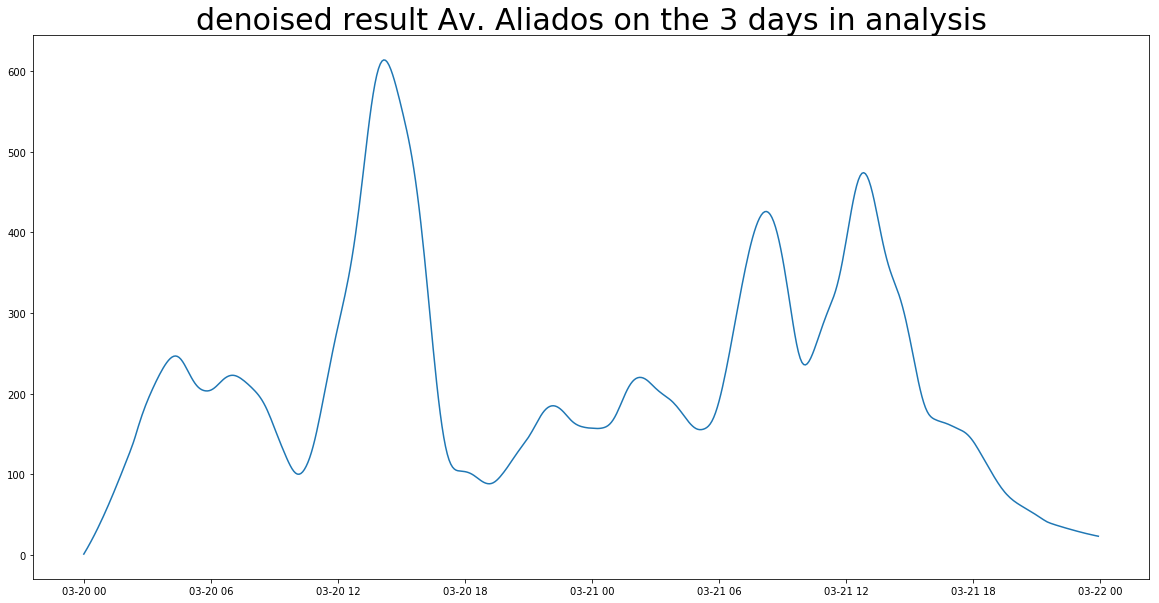

In [221]:
test2=df_sens_an[(df_sens_an["name_x"]=="Avenida do Bessa")]
plt.figure(figsize=(20,10))
plt.plot(test2["dateobservedfrom"],test2["intensity"])
plt.title("denoised result Av. Aliados on the 3 days in analysis", fontsize=30)

In [278]:
df_sens_an["hour"]=df_sens_an["dateobservedfrom"].dt.hour

In [279]:
df_sens_pred=df_sens_an.copy()

In [280]:
df_sens_grouped=df_sens_an.groupby(["name_x"])

we now create our windows

In [281]:

windows1=datetime(2018,3,20,13,0)
windows2=datetime(2018,3,20,4,0)
windows3=datetime(2018,3,21,13,0)
windows4=datetime(2018,3,21,4,0)


In [282]:
windows=[windows1,windows2,windows3,windows4]

and we compute the corresponding adjacency matrix for each window as done before, we then convert each matrix in a dataframe and we save the dataframe in a dictionary

In [ ]:
ncities=df_sens_grouped.ngroups
windows_mat={}
w=0
apikeys=["ah_Wlr8tv9ZYaXpl-ZNYBcnPjHjmhVb1ijItjoIfUoo","99VJeK8LhMbgsJV7Ci3-uzyVgvGCgyB7Ws5kjoIB7rY","YQSapqCcnEQkZnOf7Wep676YmND2whMiqjgj5z6GdQM","__M4jTOKfFKNfDLlFxF1ZtMv8YeR4XVTKx7RgQR0_oE","2yUtuxzFCoarL1pqmmJj8rGqnnCeZIx8dM8TSuW6eyo"]
for z in windows:
    timematrix= np.zeros((ncities,ncities))
    weightmatrix=np.zeros((ncities,ncities),dtype='f,f,f,f,f,f,U30,U30')

    g=0
    f=0
    date=datetime(2018,3,20,13,0) 
    for index,subframe in df_sens_grouped:
        subframe_an=subframe[((z.hour-subframe["hour"])<=3)&((z-subframe["dateobservedfrom"]).dt.days==0)].copy()
        if len(subframe_an)<37:
            continue

        lat_x=subframe_an.iloc[0]["latitude"]
        lon_x=subframe_an.iloc[0]["longitude"]
        f=0
    
        for index1, subframe1 in  df_sens_grouped:
        
            subframe1_an=subframe1[((z.hour-subframe1["hour"])<=3)&((z-subframe1["dateobservedfrom"]).dt.days==0)].copy()
    
            if len(subframe1_an)<37:
                continue
            lat_y=subframe1_an.iloc[0]["latitude"]
            lon_y=subframe1_an.iloc[0]["longitude"]
            test=subframe_an.merge(subframe1_an,how="inner",left_on='dateobservedfrom',right_on='dateobservedfrom')
            test=test.dropna()
            dist=0

            if(len(test[['intensity_x', 'intensity_y']])<37):
                continue
            while(1):
        
                res=requests.get("https://router.hereapi.com/v8/routes?transportMode=car&origin="+str(lat_x)+","+str(lon_x)+"&destination="+str(lat_y)+","+str(lon_y)+"&return=summary&departureTime="+z.strftime("%Y-%m-%dT%H:%M:%S")+"&apiKey="+apikeys[w])
                json=res.json()
                if "routes" in json.keys():
                    break
                else:
                    
                    w=w+1
                    if w==len(apikeys):
                        w=0
        
            for i in range(len(json["routes"][0]["sections"])):
            
                   dist=dist+json["routes"][0]["sections"][i]["summary"]["duration"]
             
        
            lag=round(dist/(60*5)) 
        
        
            test[["dateobservedto_y","intensity_y","laneid_y","date_from_y","time_from_y","name_x_y","name_y_y","latitude_y","longitude_y","hour_y"]] = test[["dateobservedto_y","intensity_y","laneid_y","date_from_y","time_from_y","name_x_y","name_y_y","latitude_y","longitude_y","hour_y"]].shift(lag)
        
            print(len(test[['intensity_x', 'intensity_y']]))
       
            test=test.dropna()
            test["diff_quad"]=(test["intensity_x"]-test["intensity_y"])**2
            weight=test["diff_quad"].mean()
            weightmatrix[g][f]=(weight,dist,lat_x,lon_x,lat_y,lon_y,index,index1)
            print("i="+str(g)+" f="+str(f)+" val="+str(dist)+" weight="+str(weight)+" date="+z.strftime("%Y-%m-%dT%H:%M:%S")+" api used="+str(w))
            f=f+1
        
        
        
        g=g+1
    
    windows_mat[z.strftime("%Y-%m-%dT%H:%M:%S")]=weightmatrix
    
    

In [205]:
datesq=list(map(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S"),windows))

In [283]:
dataframe_windows = {name: pd.DataFrame() for name in datesq}

In [284]:
for h in dataframe_windows:
  
    latx=[]
    lonx=[]
    laty=[]
    lony=[]
    time=[]
    weight=[]
    start=[]
    end=[]
    for i in range(len(weightmatrix)):
        for j in range(len(weightmatrix[i])):
            if (weightmatrix[i][j][0]!=0):
                weight.append(weightmatrix[i][j][0])
                time.append(weightmatrix[i][j][1])
                latx.append(weightmatrix[i][j][2])
                lonx.append(weightmatrix[i][j][3])
                laty.append(weightmatrix[i][j][4])
                lony.append(weightmatrix[i][j][5])
                start.append(weightmatrix[i][j][6])
                end.append(weightmatrix[i][j][7])
    rel= {'start': start, 'end': end, 'weight': weight,'travel_time':time,'lat_start':latx,'lon_start':lonx,'lat_end':laty,'lon_end':lony}
    relations = pd.DataFrame(data=rel)
    dataframe_windows[h]=relations.copy()

this is our final result for one street:

In [285]:
dataframe_windows["2018-03-20T04:00:00"].head(10)

,start,end,weight,travel_time,lat_start,lon_start,lat_end,lon_end
0,Alameda das Antas,Av. Aliados,79.780983,438.0,41.163254,-8.586267,41.146935,-8.611129
1,Alameda das Antas,Av. D. Afonso Henriques,995.610229,480.0,41.163254,-8.586267,41.144810,-8.610845
2,Alameda das Antas,Av. Fernão Magalhães,67.113914,139.0,41.163254,-8.586267,41.157761,-8.593809
3,Alameda das Antas,Av. Fernão Magalhães - 24 de A,896.596741,222.0,41.163254,-8.586267,41.151497,-8.597432
4,Alameda das Antas,Av. Fernão Magalhães - N-S,3520.658203,98.0,41.163254,-8.586267,41.165325,-8.589031
5,Alameda das Antas,Av. Fernão Magalhães N-S - Tún,111.058281,104.0,41.163254,-8.586267,41.164806,-8.589134
6,Alameda das Antas,Av. Fernão de Magalhães - Fran,113.446861,122.0,41.163254,-8.586267,41.163433,-8.590074
7,Alameda das Antas,Av. Rodrigues de Freitas,84.962494,394.0,41.163254,-8.586267,41.145782,-8.600481
8,Alameda das Antas,Av. Rodrigues de Freitas - S.,175.210388,417.0,41.163254,-8.586267,41.145645,-8.602294
9,Alameda das Antas,Av.Boavista - E-O,101.518997,678.0,41.163254,-8.586267,41.167431,-8.685493


we then compute the mean weight for each window element of the dataframe, our final result is a dictionary that has as key the window period and as value a dataframe of streets with the meanweight, meaning how the traffic of a streed is related to traffic of nearby streets.<br>
A little remark, those weight are calculated, not estimated so, at each time of the day i'm able to compute the weights 

In [291]:

for i in dataframe_windows:
   # dataframe_windows[i]=dataframe_windows[i][(dataframe_windows[i]["weight"]<500)&dataframe_windows[i]["travel_time"]<1000]

# we map the travel time in probability levels 
    dataframe_windows[i]["travel_time"]=dataframe_windows[i]["travel_time"]/dataframe_windows[i]["travel_time"].sum()
    #we compute the weighted average of the weights with the travel time 
    dataframe_windows[i]["weight"]=dataframe_windows[i]["weight"]*dataframe_windows[i]["travel_time"]
   
    
    df_stre=dataframe_windows[i].groupby(['start'])
   
    df_stre=df_stre[["start","weight","travel_time","lat_start","lon_start"]].mean().reset_index()
    dataframe_windows[i]=df_stre.copy()
    dataframe_windows[i]["weight"]=-dataframe_windows[i]["weight"]
   # dataframe_windows[i]["weight"]=dataframe_windows[i]["weight"]/dataframe_windows[i]["weight"].sum()
   

In [292]:

dataframe_concat = {name: pd.DataFrame() for name in datesq}
for i in dataframe_windows:
    dat=datetime.strptime(i, '%Y-%m-%dT%H:%M:%S') 
    dat_h=dat.hour
    dat=dat.date()
   
    if dat_h==13:
        df_comp=df_sens_an[(df_sens_an["dateobservedfrom"].dt.date==dat)&(df_sens_an["hour"]>=8)&(df_sens_an["hour"]<23)]
    else:
        df_comp=df_sens_an[(df_sens_an["dateobservedfrom"].dt.date==dat)&(df_sens_an["hour"]<8)&(df_sens_an["hour"]>=0)]
    df_comp["mask"]=i
    df_comp=df_comp.merge(dataframe_windows[i],how="left",left_on="name_x",right_on="start")
    dataframe_concat[i]=df_comp
df_sens_an=pd.concat(dataframe_concat)

C:\Users\michele\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


now each different sensor data at a given time has its corresponding weight relative to its window.


now we want to define, the interval of prediction, we will compare the mse of prediction predicting  aggregating them hourly and predicting the next hour,  or in intervals of 3 hours to see where our model performs better(potentially we could test with a lot of different time scales )

we will then try to forecast the hourly traffic level of one street: Avenida do Bessa

In [296]:
test_an=df_sens_an[(df_sens_an["name_x"]=="Avenida do Bessa")]

In [298]:
test_an=test_an.groupby(["name_x","mask","hour"]).mean().reset_index()

for reasons of time limitation the we changed our model, we used an armax model using the weight computed before as an exogenous variable

### result explanation 

after running the model( we tuned the hyperparameters p and q using genetic hyperparameters optimisation and  after that we could see a constant mse of ~0.843  across all the times we tried to predict(1 hour step), meaning we simply imputed the previous values and tried to predict the next one.
<br> clearly our hourly prediction was stronger than our 3 hourly prediction(mse of ~0.741), because of the lack of datapoints due to the fact that we included only 3 days in the analysis, would be interesting in the future to extend the analysis to a wider time interval 

### limitations and scalability

the main limitation is the high computational requirement for doing the analysis, infact computing the window matrix take a lot of time even with our simplification of the model, this is the main reason we decided to not include a neural network model ( like a rnn) because to work effectively needs a lot of datapoints, and consequently a lot of windows matrices, our machines were not sufficiently capables of handling such a task 

### impact calculator

if we assumes that we can use our traffic prediction model with a traffic optimisation algorithm to route decrease the traffic levels, and we are able to reduce the traffic not to include congestion, we tried to use the same api but with the parameter: no traffic, to see how long will take to move over 2 locations( the one tested before )

In [305]:
res=requests.get("https://router.hereapi.com/v8/routes?transportMode=car&origin="+str(lat_x)+","+str(lon_x)+"&destination="+str(lat_y)+","+str(lon_y)+"&return=summary&departureTime=2018-03-20T13:05:00&apiKey=__M4jTOKfFKNfDLlFxF1ZtMv8YeR4XVTKx7RgQR0_oE")



json=res.json()


In [308]:
dist=0
for i in range(len(json["routes"][0]["sections"])):
               dist=dist+json["routes"][0]["sections"][i]["summary"]["duration"]


In [309]:
dist

900

and if we do the same disabling traffic we are able to reduce travelling time by 20%, so testing it in one for each street,we will make a huge impact 